In [1]:
from neuron import h
import pandas as pd
import numpy as np

from cell_inference.cells.stylizedcell import StylizedCell, CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.ecp import EcpMod, move_position
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.utils.currents.pointcurrent import PointCurrent
from cell_inference.utils.feature_extractors.parameterprediction import Parameters, ClassifierTypes, ClassifierBuilder

from cell_inference.config import params, paths


h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

### Set parameters

Default parameters

In [2]:
loc_param = [0,0,50,np.pi/4,1,0]  # position (x,y,z,alpha,h,phi)
geo_param = [8.,600.,1.25,.28,.28,200.]  # (soma r,trunk l,trunk r,basal r,tuft r,dend l), bounds([3,12],[20,800],[0.6,2.],[0.1,0.8],[0.1,0.8],[100,300])
geo_name = ['soma r','trunk l','trunk r','basal r','tuft r','dend l']
biophys = [-1] # (g_pas of soma, basal, apical, gNaTa_t of soma, apical, gSKv3_1 of soma, apical) (3.3e-5, 6.3e-5, 8.8e-5, 2.43, 0.0252, 0.983, 0.0112)

Algorithm parameters

In [3]:
geo_idx = [0, 1, 2]
geo_range = [[7., 12.], [20., 800.], [.6, 1.8]]  # soma r 7-12, trunk l 20-800, trunk r 0.6,1.8
gmax = 0.01  # select inital gmax
find_gmax_range = False
save_results = True

In [4]:
from typing import Union, List, Tuple
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
%matplotlib inline

def quick_build(geo_idx: Tuple, geo_values: np.ndarray, gmax: Union[float, np.ndarray] = .01) -> Simulation:
    ncell = geo_values.shape[0]
    geo_parameters = np.tile(np.array(geo_param),(ncell,1))
    for idx, val in zip(geo_idx,geo_values.T):
        geo_parameters[:,idx] = val
    sim = Simulation(geometry = geo_standard, 
                     cell_type = CellTypes.ACTIVE, 
                     loc_param = loc_param, 
                     geo_param = geo_parameters, 
                     biophys = biophys, 
                     ncell = ncell, 
                     spike_threshold = -30, 
                     gmax = gmax, 
                     scale = 1.)
    return sim

def sim_builder(geo_var: List[Tuple[int,List[float]]], gmax: float = .01) -> Simulation:
    """ geo_var: List of Tuples ( Parameter entry, List of values ), variable parameters to loop over """
    geo_idx, values = zip(*geo_var)
    geo_values = np.column_stack([x.ravel() for x in np.meshgrid(*values,indexing='ij')])
    sim = quick_build(geo_idx=geo_idx, geo_values=geo_values, gmax=gmax)
    return sim, geo_idx, geo_values

def plot_v(sim: Simulation, geo_idx: Tuple[int], geo_values: np.ndarray,
           figsize: Union[List[float],Tuple[float]] = (6,2)) -> Tuple[Figure, Axes]:
    t = sim.t()
    v = sim.v('all')
    fig, axs = plt.subplots(nrows=sim.ncell, ncols=1)
    fig.set_size_inches(figsize[0],figsize[1]*sim.ncell)
    for i,ax in enumerate(axs):
        ax.plot(t,v[i,:],label=', '.join(map(str,geo_values[i])))
        ax.set_ylabel('Vm (mV)')
        ax.legend(loc=1)
    axs[0].set_title(', '.join([geo_name[i] for i in geo_idx]))
    axs[-1].set_xlabel('Time (ms)')
    return fig, axs

def valid_count(sim):
    # number of valid spiking cells
    nspk = sim.get_spike_number('all')
    nvalid = np.count_nonzero(nspk == 1)
    return nvalid

### Initial simulation check

Show cases at geometry parameter bounds.

In [5]:
if find_gmax_range:
    geo_range_pack = [*zip(geo_idx,geo_range)]
    sim, geo_idx, geo_values = sim_builder(geo_range_pack,gmax=gmax)
    sim.run_neuron_sim()
    
    print("Number of valid sample: %d" % (valid_count(sim)))
    _ = plot_v(sim, geo_idx, geo_values)

Search bounds for gmax up to no valid sample. Use bisection to help find the bounds.

In [6]:
from scipy.optimize import bisect

def find_bound(sim,gmax,coarse_bounds,tol):
    def func(g):
        sim.set_gmax(g)
        sim.run_neuron_sim()
        return valid_count(sim)-0.5
    
    xtol = tol*gmax
    glo,r1 = bisect(func,coarse_bounds[0],gmax,xtol=xtol,full_output=True)
    ghi,r2 = bisect(func,gmax,coarse_bounds[1],xtol=xtol,full_output=True)
    print("Function calls: %d, %d" % (r1.function_calls,r2.function_calls))
    return [glo-xtol,ghi+xtol]

if find_gmax_range:
    gmax_range = find_bound(sim,gmax,(gmax*0.1,gmax*8),0.01)
else:
    gmax_range = [0.0037828125000000006, 0.06007070312500001]

print(gmax_range)

[0.0037828125000000006, 0.06007070312500001]


Check result gmax bound.

In [7]:
if find_gmax_range:
    sim.set_gmax(gmax_range[1])
#     sim.set_gmax(0.023)
    sim.run_neuron_sim()

    print("Number of valid sample: %d" % (valid_count(sim)))
    _ = plot_v(sim, geo_idx, geo_values)

Save or load settings

In [8]:
from cell_inference.config import paths
import h5py

if save_results:
    if find_gmax_range:
        hf = h5py.File(paths.GMAX_MAPPING, 'w')
        grp = hf.create_group('settings')
        _ = grp.create_dataset('geo_index', data=np.asarray(geo_idx))
        _ = grp.create_dataset('geo_range', data=np.asarray(geo_range))
        _ = grp.create_dataset('gmax_range', data=np.asarray(gmax_range))
        hf.close()
    else:
        hf = h5py.File(paths.GMAX_MAPPING, 'r')
        geo_idx = hf['settings/geo_index'][()]
        geo_range = hf['settings/geo_range'][()]
        gmax_range = hf['settings/gmax_range'][()]
        hf.close()

In [9]:
print("Settings:")
print("geo_index:", geo_idx)
print("geo_range:", np.asarray(geo_range).tolist())
print("gmax_range:", gmax_range)

Settings:
geo_index: [0 1 2]
geo_range: [[7.0, 12.0], [20.0, 800.0], [0.6, 1.8]]
gmax_range: [0.00378281 0.0600707 ]


### Simulate samples in grid of parameter space

In [10]:
if find_gmax_range:
    raise SystemExit("Decide gmax range and restart notebook with find_gmax_range=False")

ngmax = 6  # number of gmax values
npoints = 6  # number of geometry parameter values
square_soma_r = True  # Using soma_r^2

grid_shape = tuple(np.concatenate(([ngmax],np.repeat(npoints,len(geo_idx)))))
nsamples = np.prod(grid_shape[1:])
geo_var = []
for i, x in zip(geo_idx,geo_range):
    if square_soma_r and i==0:  # Using soma_r^2
        geo_var.append((i, np.linspace(*np.asarray(x)**2, num=npoints)**0.5))
    else:
        geo_var.append((i, np.linspace(*x, num=npoints)))
gmax_var = np.linspace(*gmax_range,num=ngmax)

sim, geo_idx, geo_values = sim_builder(geo_var,gmax=gmax_var[0])

geo_values0 = geo_values.copy()
if square_soma_r: geo_values[:,np.nonzero(np.array(geo_idx)==0)[0]] **= 2  # Using soma_r^2

Run simulations over grids.

In [11]:
import time

t00 = time.time()

spike_count = np.empty((ngmax,nsamples), dtype=int)
for i in range(ngmax):
    t0 = time.time()
    sim.set_gmax(gmax_var[i])
    sim.run_neuron_sim()
    spike_count[i] = sim.get_spike_number('all')
    print("Iteration %d, Run time : %.1f" % (i + 1, time.time() - t0))

print("Total run time: %.1f" % (time.time() - t00))

Iteration 1, Run time : 14.7
Iteration 2, Run time : 13.5
Iteration 3, Run time : 13.8
Iteration 4, Run time : 15.2
Iteration 5, Run time : 14.8
Iteration 6, Run time : 14.8
Total run time: 87.0


In [12]:
# Test method: stop simulating a sample with greater gmax once find the sample generates more than one spike
# import time

# t00 = time.time()

# spike_count = np.zeros((ngmax,nsamples), dtype=int)
# valid_idx = np.arange(nsamples)
# for i in range(ngmax):
#     t0 = time.time()
#     if valid_idx.size == sim.ncell:
#         sim.set_gmax(gmax_var[i])
#     else:
#         sim = quick_build(geo_idx=geo_idx, geo_values=geo_values0[valid_idx,:], gmax=gmax_var[i])
#     sim.run_neuron_sim()
#     nspk = sim.get_spike_number('all')
#     spike_count[i,valid_idx] = nspk
#     valid_idx = valid_idx[nspk<2]
#     print("Run time: %.1f" % (time.time() - t0))

# print("Total run time: %.1f" % (time.time() - t00))

Need the following to ensure increasing spike number as gmax increases. Spike amplitude in some cells may drop below threshold, resulting in decreasing spike count.

In [13]:
for i in range(1,ngmax):
    spike_count[i] = np.maximum(spike_count[i-1],spike_count[i])
print(spike_count)

[[0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 2 2 2]]


Get index of valid samples with only one spike.

In [14]:
valid_samples = spike_count.ravel()==1
valid_grid = valid_samples.reshape(grid_shape)
print(valid_grid.astype(int))

[[[[0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]]

  [[0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]]

  [[0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]]

  [[0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]]

  [[0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]]

  [[0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]
   [0 0 0 0 0 0]]]


 [[[1 1 1 1 1 1]
   [1 1 1 1 1 1]
   [1 1 1 1 1 1]
   [1 1 1 1 1 1]
   [1 1 1 1 1 1]
   [1 1 1 1 1 1]]

  [[1 1 1 1 1 1]
   [1 1 1 1 1 1]
   [1 1 1 1 1 1]
   [1 1 1 1 1 1]
   [1 1 1 1 1 1]
   [1 1 1 1 1 1]]

  [[1 1 1 1 1 1]
   [1 1 1 1 1 1]
   [1 1 1 1 1 1]
   [1 1 1 1 1 1]
   [1 1 1 1 1 1]
   [1 1 1 1 1 1]]

  [[1 1 1 1 1 1]
   [1 1 1 1 1 1]
   [1 1 1 1 1 1]
   [1 1 1 1

Get training samples. Method 1: all valid samples. Method 2: averaged gmax of valid samples.

In [15]:
# Method 1
geo_samples = np.tile(geo_values,(ngmax,1))
gmax_samples = np.repeat(gmax_var,geo_values.shape[0]).reshape(-1,1)

# Method 2
valid_grid = valid_samples.reshape(grid_shape[0],nsamples).T
gmax_avg = np.array([[gmax_var[v].mean()] for v in valid_grid])

In [16]:
# Make sure valid gmax exists for every parameter grid
no_valid_idx = np.nonzero(np.isnan(gmax_avg))[0]
if no_valid_idx.size:
    print("No valid gmax found for: ")
    print(geo_values[no_valid_idx,:])

#### Fit regressor to valid samples.

In [17]:
# Method 1
# x_train = geo_samples[valid_samples]
# y_train = gmax_samples[valid_samples]

# Method 2
x_train = geo_values
y_train = gmax_avg

classifier = ClassifierBuilder(x_train, y_train, ClassifierTypes.LINEAR_REGRESSION)
classifier.fit()
classifier.save_clf(paths.RESOURCES_ROOT + "gmax_lin_reg_classifier.joblib")
lin_pred = classifier.predict(geo_values)

classifier = ClassifierBuilder(x_train, y_train, ClassifierTypes.RIDGE_REGRESSION)
classifier.fit()
classifier.save_clf(paths.RESOURCES_ROOT + "gmax_ridge_classifier.joblib")
rid_pred = classifier.predict(geo_values)


classifier = ClassifierBuilder(x_train, y_train.ravel(), ClassifierTypes.SUPPORT_VECTOR_REGRESSION)
classifier.fit()
classifier.save_clf(paths.RESOURCES_ROOT + "gmax_svr_classifier.joblib")
svr_pred = classifier.predict(geo_values)

#### Linear interpolation method

In [18]:
from scipy.interpolate import LinearNDInterpolator

gmax_interp = LinearNDInterpolator(geo_values, gmax_avg)
intep_pred = gmax_interp(geo_values)

#### Visualizing result

<IPython.core.display.Javascript object>


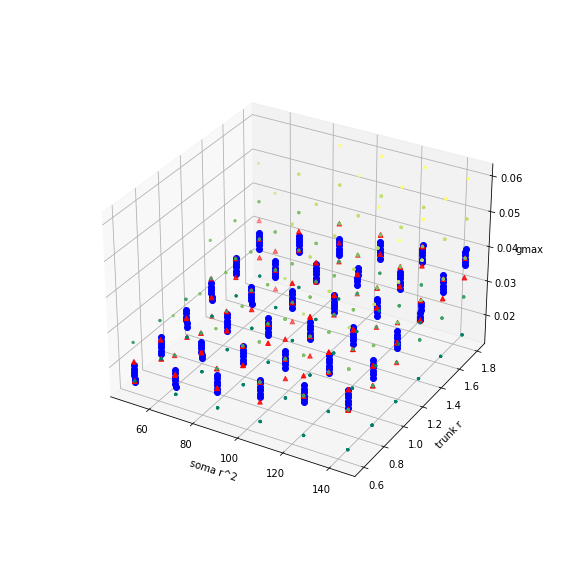

In [19]:
%matplotlib notebook

geo_show = [0,2]
label_names = []
for i in geo_show:
    idx = geo_idx[i]
    label_names.append(geo_name[idx])
    if square_soma_r and idx==0: label_names[-1] += '^2'  # Using soma_r^2

plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(geo_samples[valid_samples,geo_show[0]],geo_samples[valid_samples,geo_show[1]],
             gmax_samples[valid_samples,0],c=gmax_samples[valid_samples,0],cmap='summer',marker='.')
ax.scatter3D(geo_values[:,geo_show[0]],geo_values[:,geo_show[1]],gmax_avg[:,0],c='r',marker='^')
ax.plot3D(geo_values[:,geo_show[0]],geo_values[:,geo_show[1]],lin_pred[:,0],'bo')
# ax.plot3D(geo_values[:,geo_show[0]],geo_values[:,geo_show[1]],rid_pred[:,0],'ro')
# ax.plot3D(geo_values[:,geo_show[0]],geo_values[:,geo_show[1]],svr_pred,'go')
ax.set_xlabel(label_names[0])
ax.set_ylabel(label_names[1])
ax.set_zlabel('gmax')
plt.show()

#### Check predicted gmax performance

Check linear regressor

In [20]:
sim = quick_build(geo_idx=geo_idx, geo_values=geo_values0, gmax=lin_pred)
sim.run_neuron_sim()

In [21]:
print("Number of valid sample: %d out of %d" % (valid_count(sim),sim.ncell))
spike_count = sim.get_spike_number('all').reshape(grid_shape[1:])
if valid_count(sim) != sim.ncell:
    print(spike_count)

Number of valid sample: 216 out of 216


Check interpolator

In [22]:
nrand = 100
geo_rand = np.random.uniform(low=np.asarray(geo_range).T[0,:], high=np.asarray(geo_range).T[1,:], size=(nrand,len(geo_idx)))

geo_rand0 = geo_rand.copy()
if square_soma_r: geo_rand[:,np.nonzero(np.array(geo_idx)==0)[0]] **= 2  # Using soma_r^2

gmax_rand = gmax_interp(geo_rand)

In [23]:
sim = quick_build(geo_idx=geo_idx, geo_values=geo_rand0, gmax=gmax_rand)
sim.run_neuron_sim()

In [24]:
print("Number of valid sample: %d out of %d" % (valid_count(sim),sim.ncell))
spike_count = sim.get_spike_number('all')
if valid_count(sim) != sim.ncell:
    print(spike_count)

Number of valid sample: 100 out of 100


#### Save mapping data

In [25]:
from cell_inference.config import paths
import h5py

if save_results:
    hf = h5py.File(paths.GMAX_MAPPING, 'w')
    grp = hf.create_group('settings')
    _ = grp.create_dataset('geo_index', data=np.asarray(geo_idx))
    _ = grp.create_dataset('geo_range', data=np.asarray(geo_range))
    _ = grp.create_dataset('gmax_range', data=np.asarray(gmax_range))

    grp = hf.create_group('mapping')
    grp.attrs.create('squared_soma_radius', square_soma_r, dtype=bool)
    _, geo_grid = zip(*geo_var)
    _ = grp.create_dataset('geo_grid', data=np.asarray(geo_grid))
    _ = grp.create_dataset('geometry', data=np.asarray(geo_values))
    _ = grp.create_dataset('gmax', data=np.asarray(gmax_avg))
    hf.close()

In [26]:
hf = h5py.File(paths.GMAX_MAPPING, 'r')
hf.visit(print)

print(hf['settings/geo_index'][()])
print(hf['settings/geo_range'][()])
print(hf['settings/gmax_range'][()])

print(hf['mapping'].attrs['squared_soma_radius'])
print(hf['mapping/geo_grid'].shape)  # (soma radius original values)
print(hf['mapping/geometry'].shape)  # (soma radius squared)
print(hf['mapping/gmax'].shape)
hf.close()

mapping
mapping/geo_grid
mapping/geometry
mapping/gmax
settings
settings/geo_index
settings/geo_range
settings/gmax_range
[0 1 2]
[[7.0e+00 1.2e+01]
 [2.0e+01 8.0e+02]
 [6.0e-01 1.8e+00]]
[0.00378281 0.0600707 ]
True
(3, 6)
(216, 3)
(216, 1)
